# Initial EDA
#### UK Power Networks (bw/ November 2011 - February 2014)


## 1) Load Required Libraries

In [2]:
library("tidyverse")
library("lubridate")
library("janitor")

## 2) Load Data

### 2.1) Load UKPW Consumption Dataset

In [3]:
ukpw_consumption_df <- read.csv(file="data/Power-Networks-LCL-June2015(withAcornGps)v2.csv", header=TRUE, sep=",")
ukpw_consumption_df$stdorToU <- as.factor(ukpw_consumption_df$stdorToU)
ukpw_consumption_df$DateTime <- ymd_hms(as.character(ukpw_consumption_df$DateTime))
ukpw_consumption_df$KWH_hh_per_half_hour <- as.numeric(as.character(ukpw_consumption_df$`KWH.hh..per.half.hour.`))
ukpw_consumption_df$`KWH.hh..per.half.hour.` <- NULL
ukpw_consumption_df$Acorn <- NULL
#ukpw_consumption_df$Acorn <- as.factor(ukpw_consumption_df$Acorn)
ukpw_consumption_df$Acorn_grouped <- as.factor(ukpw_consumption_df$Acorn_grouped)
ukpw_consumption_df <- as.tibble(ukpw_consumption_df)
glimpse(ukpw_consumption_df)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

Observations: 167,932,474
Variables: 5
$ LCLid                <fct> MAC000002, MAC000002, MAC000002, MAC000002, MAC0…
$ stdorToU             <fct> Std, Std, Std, Std, Std, Std, Std, Std, Std, Std…
$ DateTime             <dttm> 2012-10-12 00:30:00, 2012-10-12 01:00:00, 2012-…
$ Acorn_grouped        <fct> Affluent, Affluent, Affluent, Affluent, Affluent…
$ KWH_hh_per_half_hour <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,…


### 2.2) Load UKPW Tariff Dataset

In [4]:
ukpw_tariffs_df <- read.csv(file="data/Tariffs.csv", header=TRUE, sep=",")
ukpw_tariffs_df$DateTime <- mdy_hm(as.character(ukpw_tariffs_df$TariffDateTime))
ukpw_tariffs_df$TariffDateTime <- NULL
glimpse(ukpw_tariffs_df)

Observations: 17,520
Variables: 2
$ Tariff   <fct> Normal, Normal, Normal, Normal, Normal, Normal, Normal, Norm…
$ DateTime <dttm> 2013-01-01 00:00:00, 2013-01-01 00:30:00, 2013-01-01 01:00:…


### 2.3) Join Both Datasets

In [5]:
ukpw_consumption_df <- ukpw_consumption_df %>% left_join(ukpw_tariffs_df, by="DateTime")

In [6]:
glimpse(ukpw_consumption_df)

Observations: 167,932,474
Variables: 6
$ LCLid                <fct> MAC000002, MAC000002, MAC000002, MAC000002, MAC0…
$ stdorToU             <fct> Std, Std, Std, Std, Std, Std, Std, Std, Std, Std…
$ DateTime             <dttm> 2012-10-12 00:30:00, 2012-10-12 01:00:00, 2012-…
$ Acorn_grouped        <fct> Affluent, Affluent, Affluent, Affluent, Affluent…
$ KWH_hh_per_half_hour <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,…
$ Tariff               <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …


### 2.4) Fix Tariffs for Standard Group

In [7]:
levels(ukpw_consumption_df$Tariff) <- c(levels(ukpw_consumption_df$Tariff), "Flat")
levels(ukpw_consumption_df$Tariff)

[1] "High"   "Low"    "Normal" "Flat"

In [8]:
ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="Std"),]$Tariff <- "Flat"

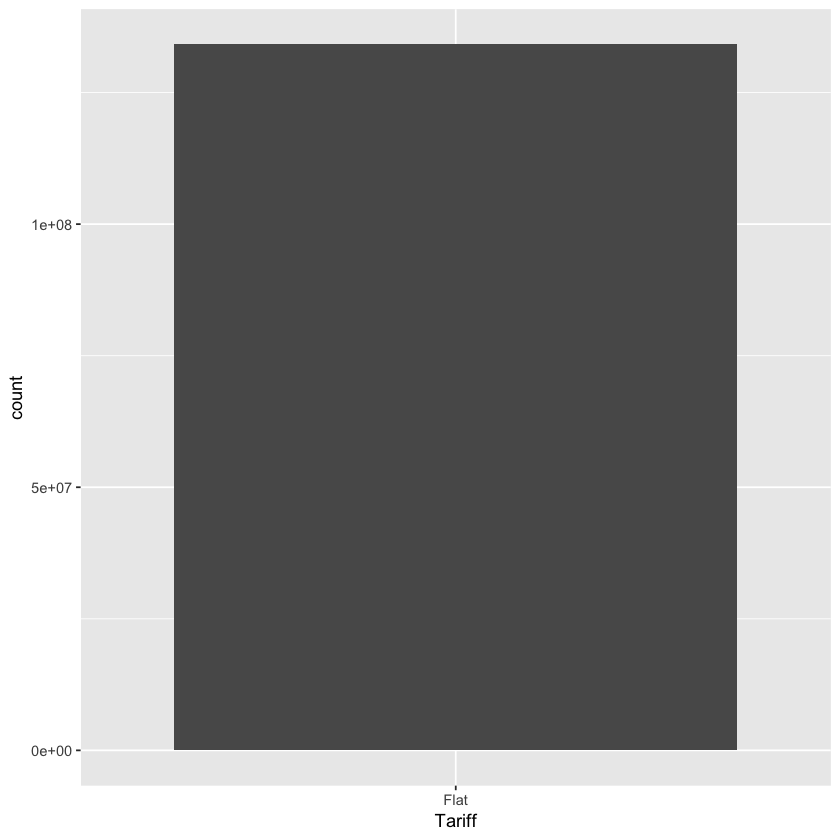

In [9]:
ggplot(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="Std"),], aes(x=Tariff)) + geom_bar()

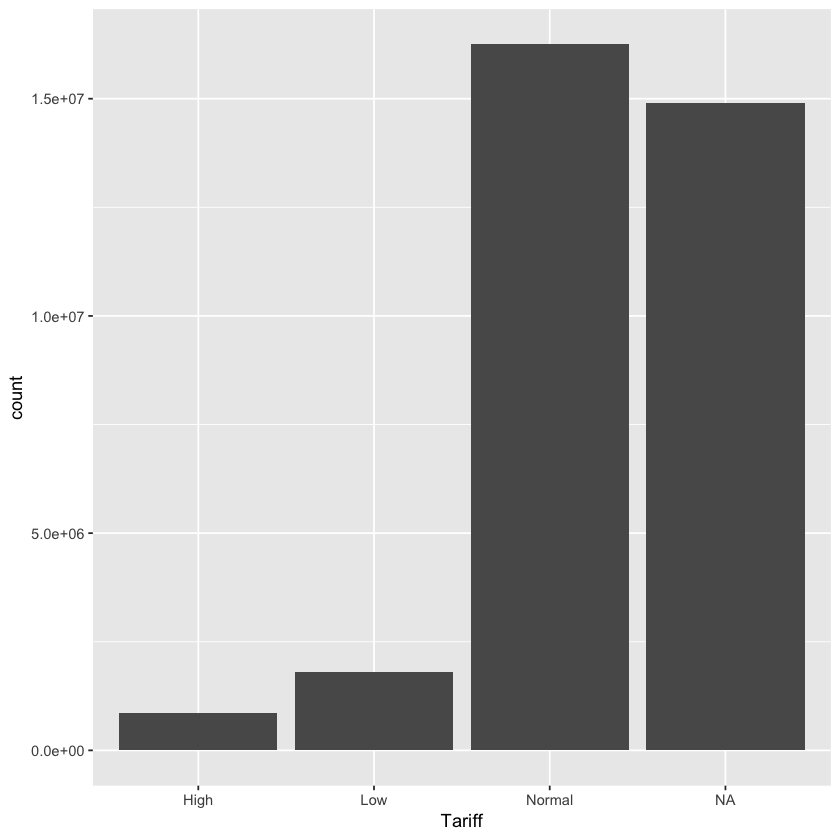

In [10]:
ggplot(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU"),], aes(x=Tariff)) + geom_bar()

### 2.5) Find out why there are periods without a Tariff

In [11]:
head(ukpw_consumption_df[which(is.na(ukpw_consumption_df$Tariff)),])

LCLid,stdorToU,DateTime,Acorn_grouped,KWH_hh_per_half_hour,Tariff
MAC000005,ToU,2012-06-01 10:30:00,Affluent,0.095,NA
MAC000005,ToU,2012-06-01 11:00:00,Affluent,0.051,NA
MAC000005,ToU,2012-06-01 11:30:00,Affluent,0.098,NA
MAC000005,ToU,2012-06-01 12:00:00,Affluent,0.087,NA
MAC000005,ToU,2012-06-01 12:30:00,Affluent,0.038,NA
MAC000005,ToU,2012-06-01 13:00:00,Affluent,0.034,NA


**Dynamic Tariff only affects 2013** 

In [12]:
min(ukpw_consumption_df$DateTime, na.rm = TRUE)

[1] "2011-11-23 09:00:00 UTC"

In [13]:
min(ukpw_tariffs_df$DateTime, na.rm = TRUE)

[1] "2013-01-01 UTC"

In [14]:
max(ukpw_tariffs_df$DateTime, na.rm = TRUE)

[1] "2013-12-31 23:30:00 UTC"

In [15]:
max(ukpw_consumption_df$DateTime, na.rm = TRUE)

[1] "2014-02-28 UTC"

**Set ToU Non-2012 Tariffs to Flat**

In [16]:
ukpw_consumption_df[which(is.na(ukpw_consumption_df$Tariff)),]$Tariff <- "Flat"

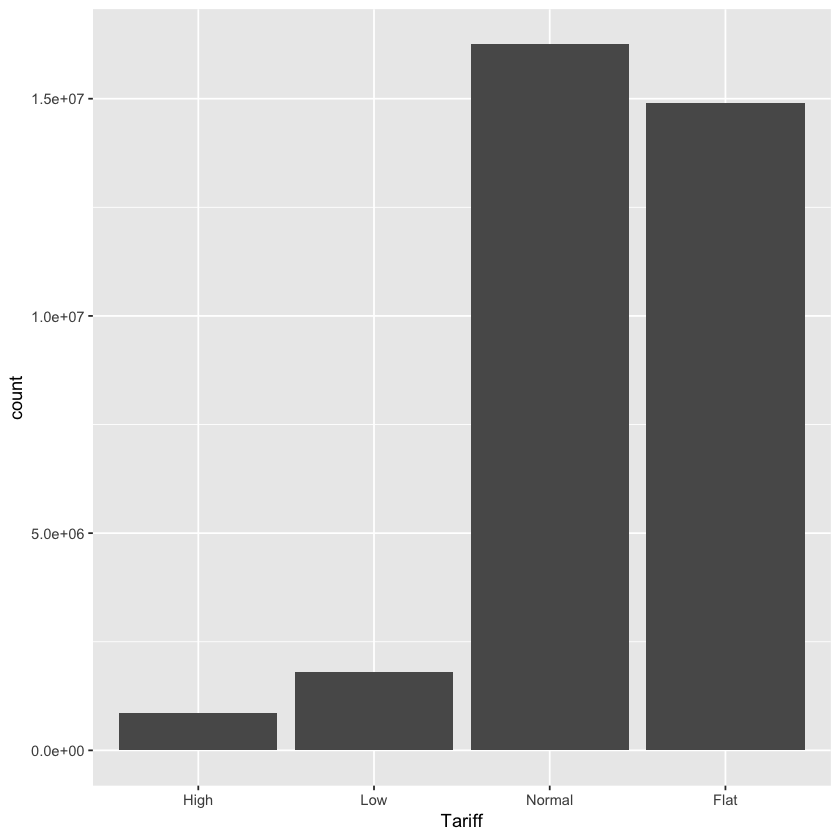

In [17]:
ggplot(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU"),], aes(x=Tariff)) + geom_bar()

## 3) Feature Engineering

### 3.1) Create Date Features

**Hour Of Day**

In [18]:
ukpw_consumption_df$DateTime_hour <- hour(ukpw_consumption_df$DateTime) + (minute(ukpw_consumption_df$DateTime)/60)

**Month**

In [19]:
ukpw_consumption_df$DateTime_month <- month(ukpw_consumption_df$DateTime) 

**Weekday**

In [20]:
ukpw_consumption_df$DateTime_wday <- wday(ukpw_consumption_df$DateTime, week_start = getOption("lubridate.week.start", 1)) #Start on Monday

**Yearday**

In [89]:
ukpw_consumption_df$DateTime_yday <- yday(ukpw_consumption_df$DateTime)

**Year**

In [90]:
ukpw_consumption_df$DateTime_year <- year(ukpw_consumption_df$DateTime) 

**Check it out**

In [21]:
glimpse(ukpw_consumption_df)

Observations: 167,932,474
Variables: 9
$ LCLid                <fct> MAC000002, MAC000002, MAC000002, MAC000002, MAC0…
$ stdorToU             <fct> Std, Std, Std, Std, Std, Std, Std, Std, Std, Std…
$ DateTime             <dttm> 2012-10-12 00:30:00, 2012-10-12 01:00:00, 2012-…
$ Acorn_grouped        <fct> Affluent, Affluent, Affluent, Affluent, Affluent…
$ KWH_hh_per_half_hour <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,…
$ Tariff               <fct> Flat, Flat, Flat, Flat, Flat, Flat, Flat, Flat, …
$ DateTime_hour        <dbl> 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0…
$ DateTime_month       <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, …
$ DateTime_wday        <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, …


### 3.2) Observe Distributions

**By Hour Of Day**

Warning message:
“position_stack requires non-overlapping x intervals”

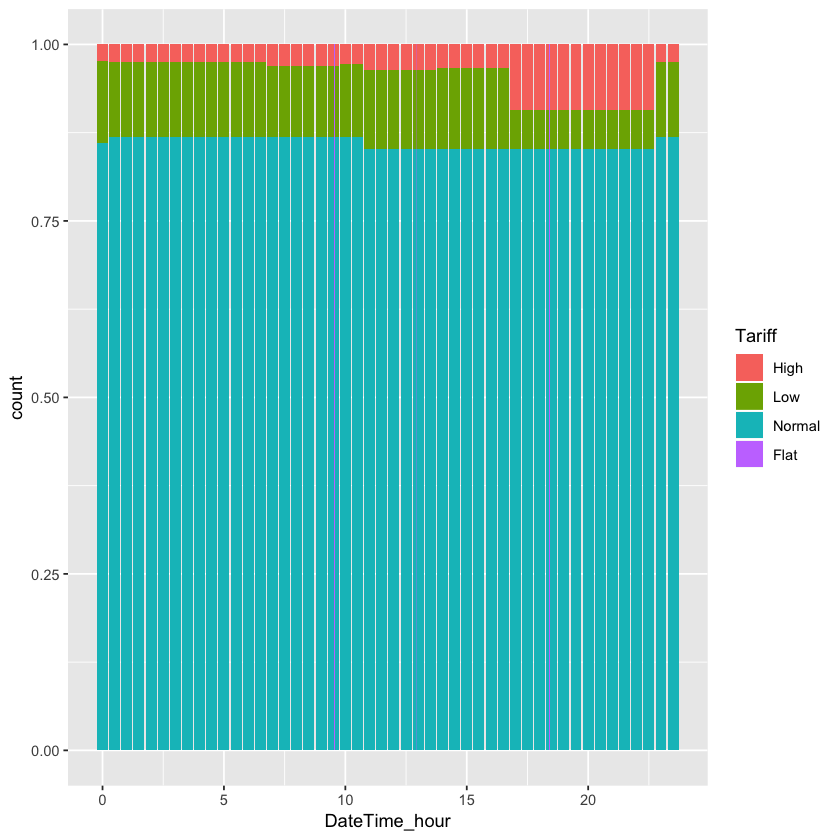

In [23]:
ggplot(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU" & year(ukpw_consumption_df$DateTime)==2013),], aes(x=DateTime_hour, fill=Tariff)) + 
        geom_bar(position="fill", stat="count")

**By Month**

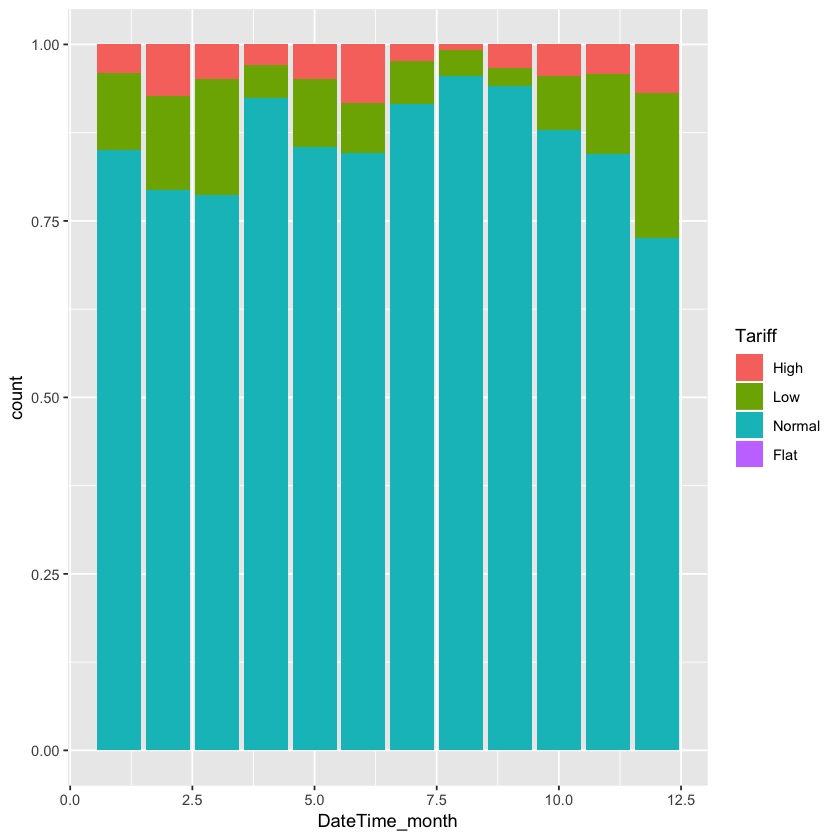

In [24]:
ggplot(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU" & year(ukpw_consumption_df$DateTime)==2013),], aes(x=DateTime_month, fill=Tariff)) + 
        geom_bar(position="fill", stat="count")

**By Weekday**

Warning message:
“position_stack requires non-overlapping x intervals”

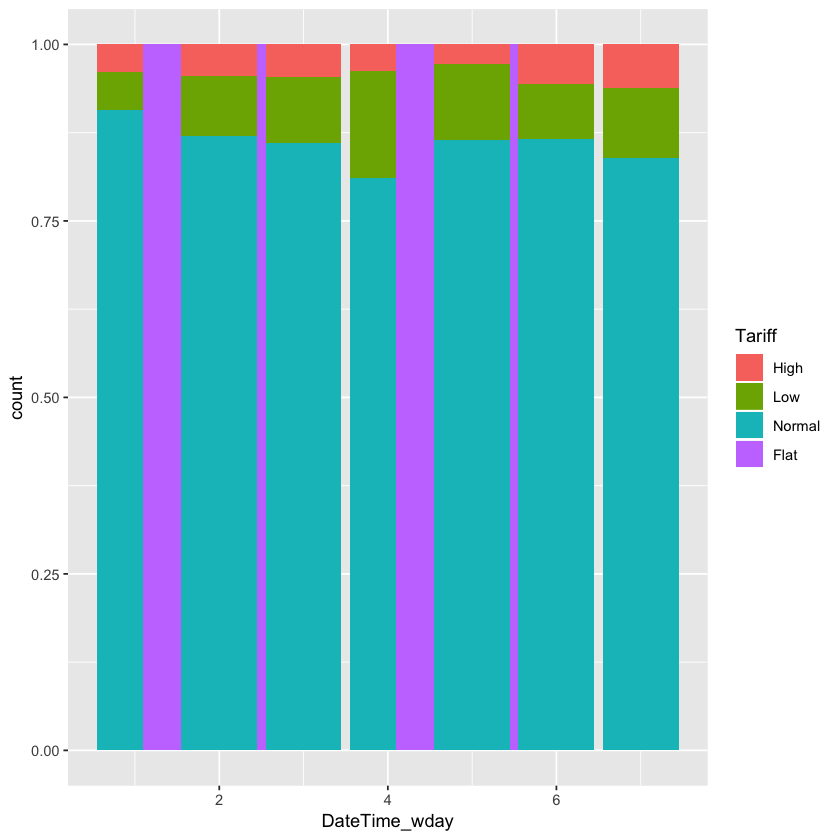

In [25]:
ggplot(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU" & year(ukpw_consumption_df$DateTime)==2013),], aes(x=DateTime_wday, fill=Tariff)) + 
        geom_bar(position="fill", stat="count")

### 3.3) Observe Usage

**By Time Of Day**

In [27]:
ToU_ToD_agg_df <- ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU" & year(ukpw_consumption_df$DateTime)==2013),] %>% 
                group_by(DateTime_hour, Tariff) %>% summarise(KWh_mean=mean(KWH_hh_per_half_hour), KWh_med=median(KWH_hh_per_half_hour)) %>% ungroup()

Warning message:
“Removed 4 rows containing missing values (geom_path).”

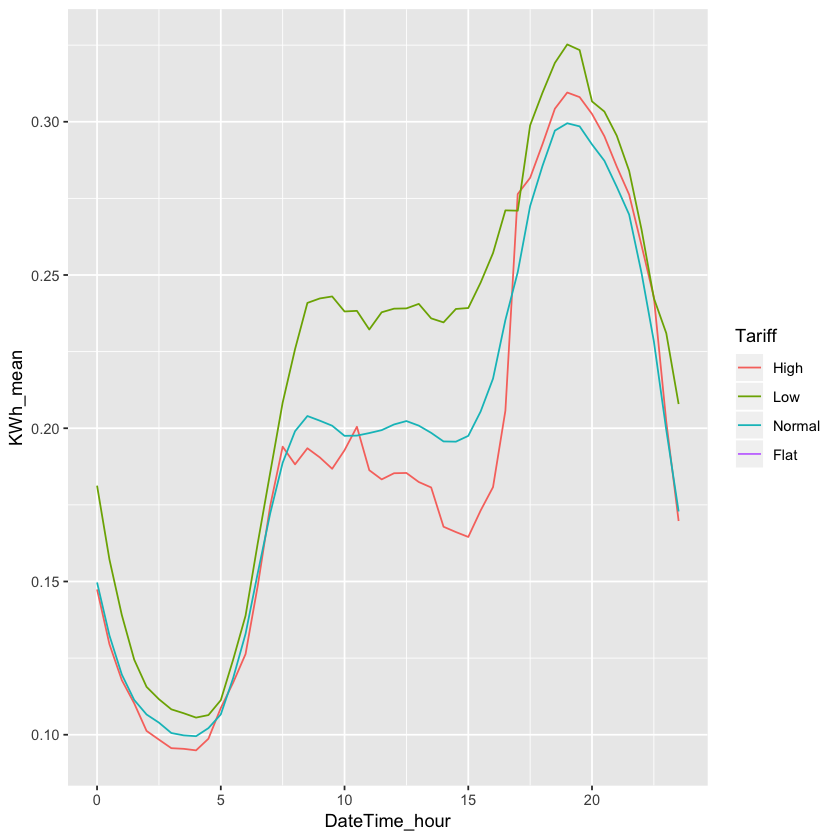

In [30]:
ggplot(ToU_ToD_agg_df, aes(x=DateTime_hour, y=KWh_mean, colour=Tariff)) + geom_line()

Warning message:
“Removed 4 rows containing missing values (geom_path).”

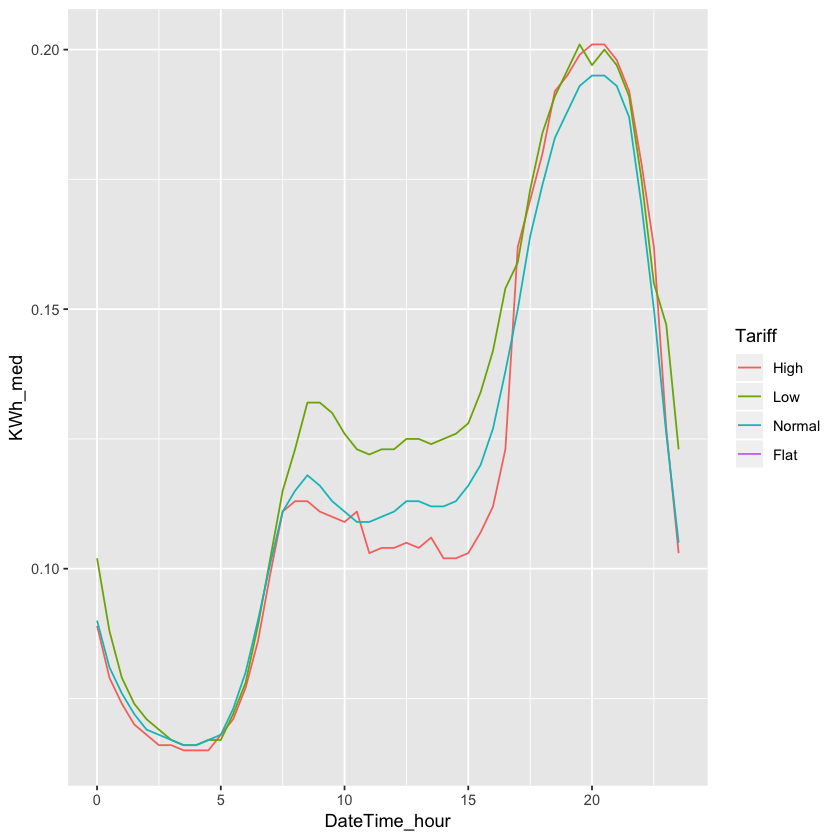

In [31]:
ggplot(ToU_ToD_agg_df, aes(x=DateTime_hour, y=KWh_med, colour=Tariff)) + geom_line()

**By Month**

In [32]:
ToU_Mon_agg_df <- ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU" & year(ukpw_consumption_df$DateTime)==2013),] %>% 
                group_by(DateTime_month, Tariff) %>% summarise(KWh_mean=mean(KWH_hh_per_half_hour), KWh_med=median(KWH_hh_per_half_hour)) %>% ungroup()

Warning message:
“Removed 3 rows containing missing values (geom_path).”

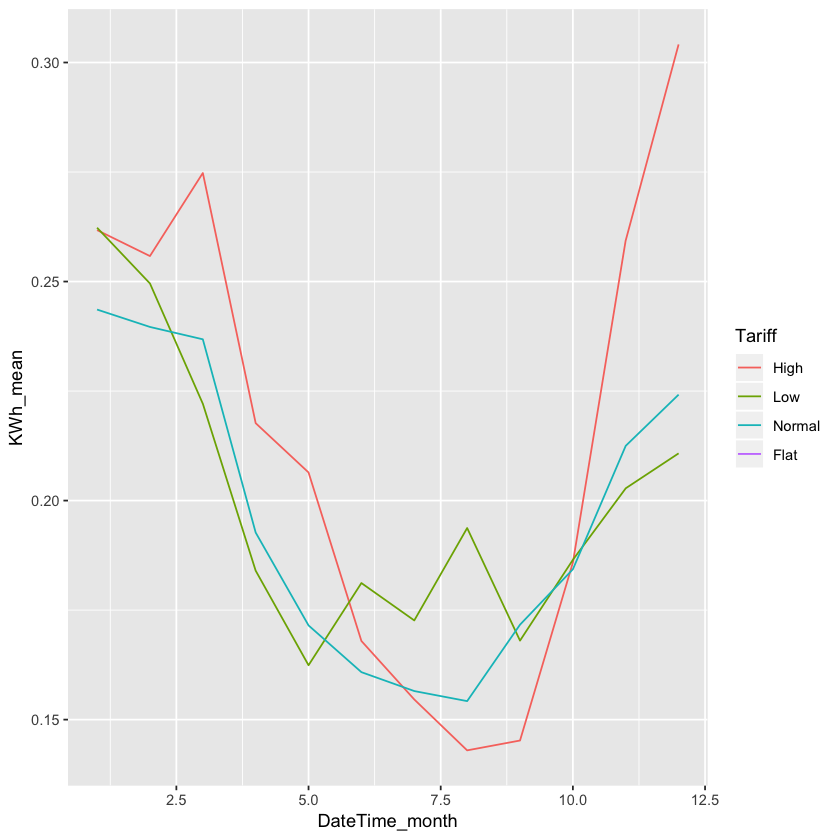

In [91]:
ggplot(ToU_Mon_agg_df, aes(x=DateTime_month, y=KWh_mean, colour=Tariff)) + geom_line()

**By Weekday**

In [35]:
ToU_DoW_agg_df <- ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=="ToU" & year(ukpw_consumption_df$DateTime)==2013),] %>% 
                group_by(DateTime_wday, Tariff) %>% summarise(KWh_mean=mean(KWH_hh_per_half_hour), KWh_med=median(KWH_hh_per_half_hour)) %>% ungroup()

Warning message:
“Removed 2 rows containing missing values (geom_path).”

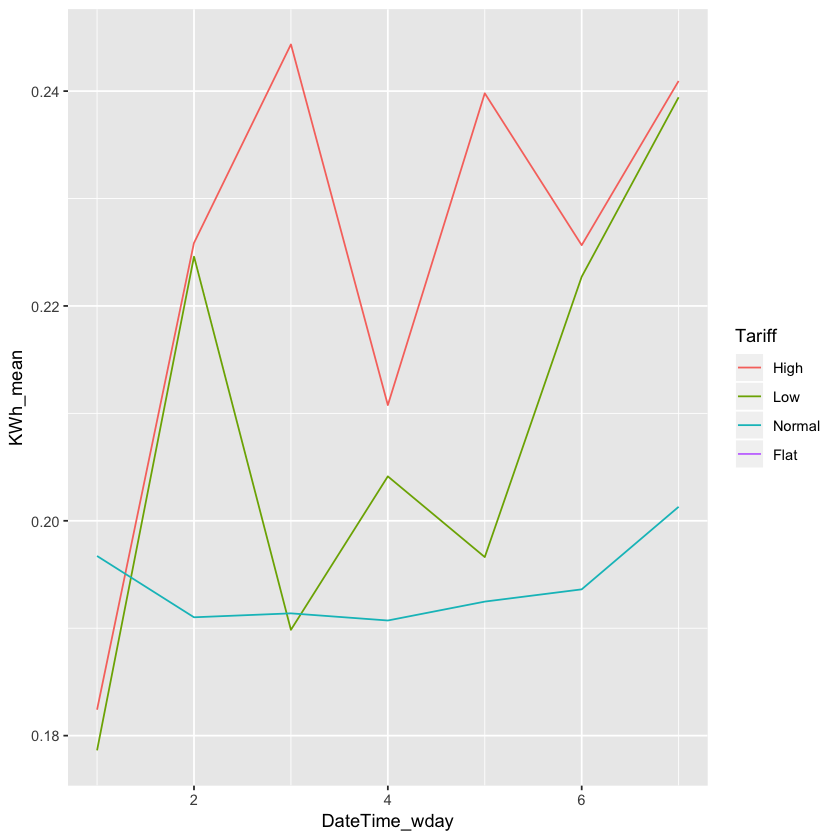

In [36]:
ggplot(ToU_DoW_agg_df, aes(x=DateTime_wday, y=KWh_mean, colour=Tariff)) + geom_line()

Warning message:
“Removed 2 rows containing missing values (geom_path).”

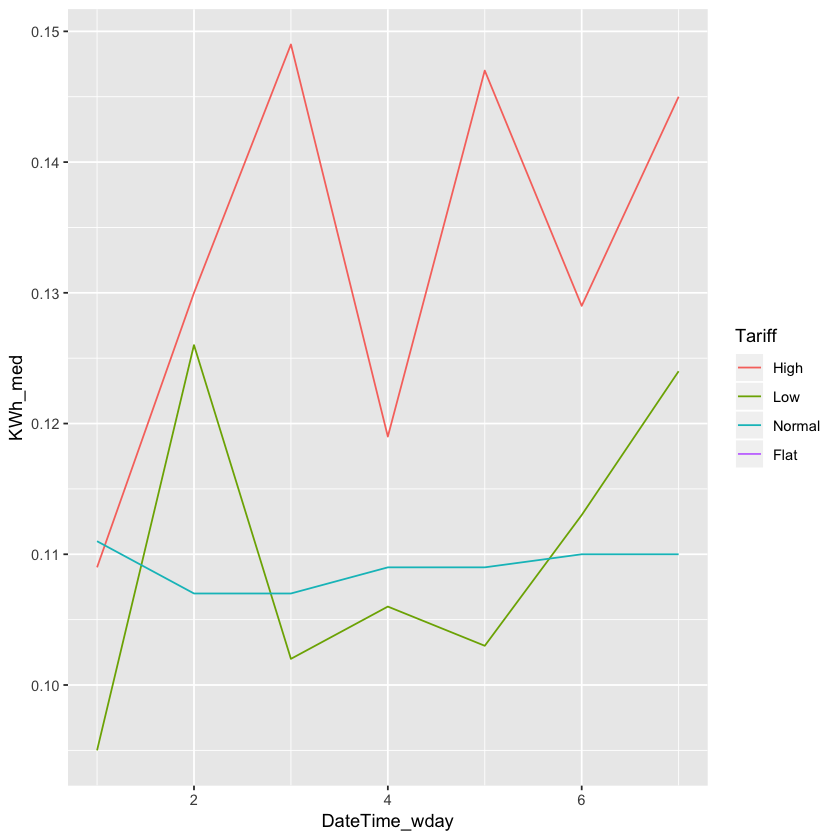

In [37]:
ggplot(ToU_DoW_agg_df, aes(x=DateTime_wday, y=KWh_med, colour=Tariff)) + geom_line()

### 3.4) Create New Level Of Demand Feature

**Calculate Estimated (Average) Level Of Demand**
(for `Flat` Tariffs only by month, weekday and hour)

In [45]:
ELoD_df <- ukpw_consumption_df[which(ukpw_consumption_df$Tariff=='Flat'),] %>% group_by(DateTime_month, DateTime_wday, DateTime_hour) %>%
             summarise(KWh_mean=mean(KWH_hh_per_half_hour, na.rm=TRUE), KWh_med=median(KWH_hh_per_half_hour, na.rm=TRUE)) %>% ungroup()

**Compare Estimated Level Of Demand Across High and Low Demand Months**

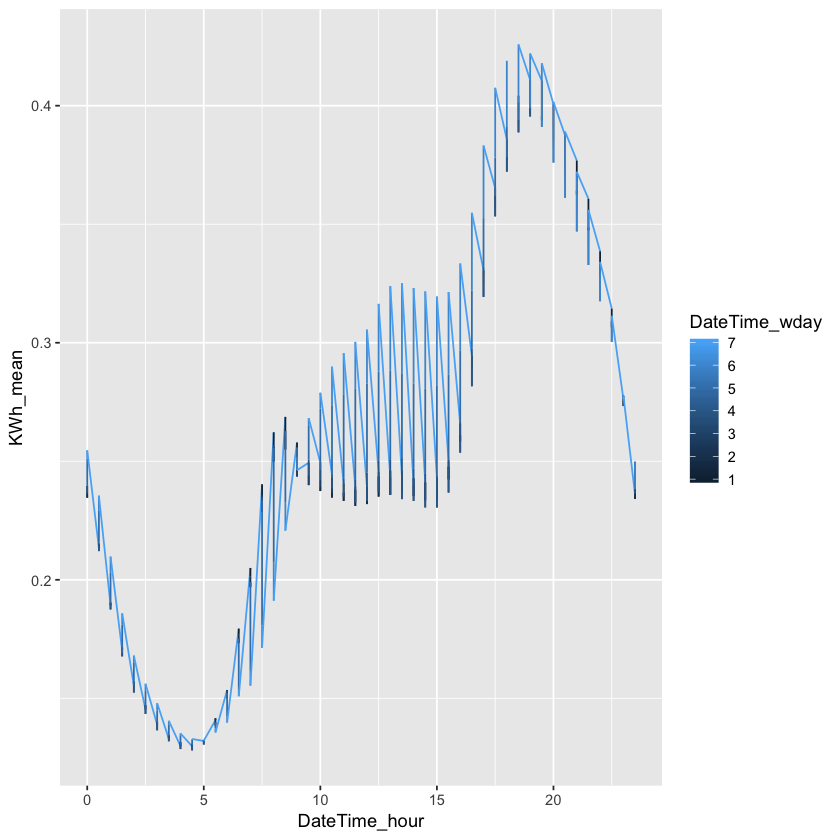

In [49]:
ggplot(ELoD_df[which(ELoD_df$DateTime_month==1),], aes(x=DateTime_hour, y=KWh_mean, colour=DateTime_wday)) + geom_line()

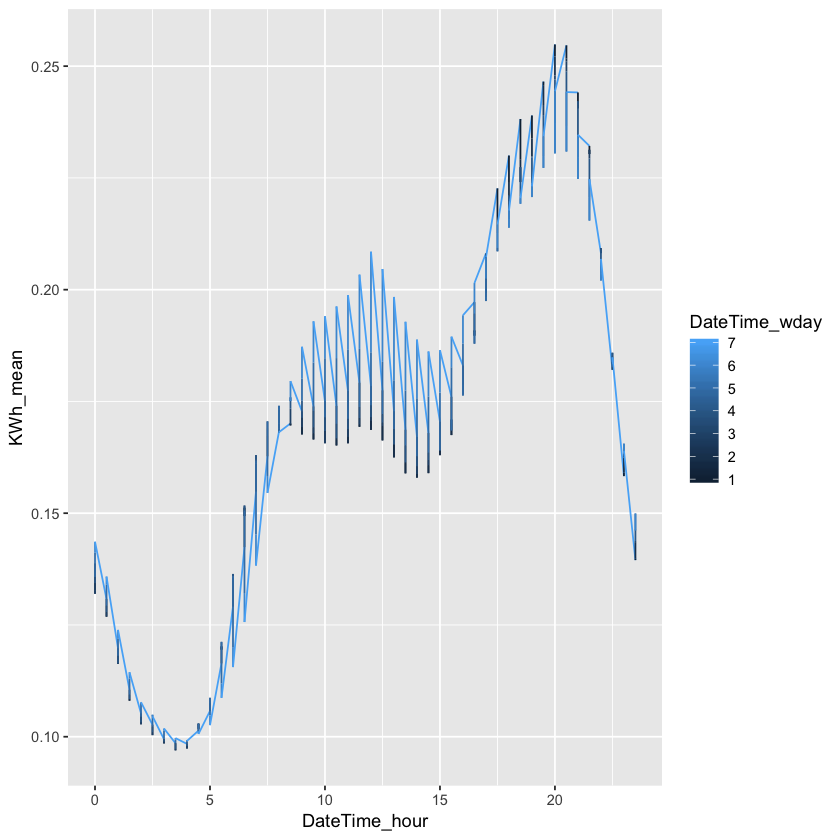

In [50]:
ggplot(ELoD_df[which(ELoD_df$DateTime_month==8),], aes(x=DateTime_hour, y=KWh_mean, colour=DateTime_wday)) + geom_line()

**Make Estimated Level Of Demand Calculation Relative to Month**

In [52]:
ELoD_nToD_df <- ukpw_consumption_df[which(ukpw_consumption_df$Tariff=='Flat'),] %>% group_by(DateTime_month, DateTime_wday) %>%
             summarise(KWh_mean=mean(KWH_hh_per_half_hour, na.rm=TRUE), KWh_med=median(KWH_hh_per_half_hour, na.rm=TRUE)) %>% 
             mutate(daily_KWh_min=KWh_mean-((KWh_mean-KWh_med)/2), daily_KWh_max=KWh_mean+((KWh_mean-KWh_med)/2)) %>% 
             rename(daily_KWh_mean=KWh_mean, daily_KWh_med=KWh_med) %>% ungroup()
ELoD_nToD_df

DateTime_month,DateTime_wday,daily_KWh_mean,daily_KWh_med,daily_KWh_min,daily_KWh_max
1,1,0.2543978,0.134,0.1941989,0.3145967
1,2,0.2493980,0.132,0.1906990,0.3080969
1,3,0.2489804,0.133,0.1909902,0.3069706
1,4,0.2472042,0.131,0.1891021,0.3053063
1,5,0.2518188,0.133,0.1924094,0.3112282
1,6,0.2598914,0.139,0.1994457,0.3203371
1,7,0.2737934,0.144,0.2088967,0.3386901
2,1,0.2468307,0.129,0.1879154,0.3057461
2,2,0.2442307,0.128,0.1861153,0.3023460
2,3,0.2460569,0.129,0.1875285,0.3045854


In [54]:
ELoD_df <- ELoD_df %>% left_join(ELoD_nToD_df, by=c("DateTime_month","DateTime_wday"))
ELoD_df$Demand <- "Normal"
ELoD_df[which(ELoD_df$KWh_mean <= ELoD_df$daily_KWh_min),]$Demand <- "Low"
ELoD_df[which(ELoD_df$KWh_mean >= ELoD_df$daily_KWh_max),]$Demand <- "High"
ELoD_df

DateTime_month,DateTime_wday,DateTime_hour,KWh_mean,KWh_med,daily_KWh_mean,daily_KWh_med,daily_KWh_min,daily_KWh_max,Demand
1,1,0.0,0.2396471,0.121,0.2543978,0.134,0.1941989,0.3145967,Normal
1,1,0.5,0.2134980,0.101,0.2543978,0.134,0.1941989,0.3145967,Normal
1,1,1.0,0.1893098,0.089,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,1.5,0.1701084,0.082,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,2.0,0.1553902,0.077,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,2.5,0.1453611,0.075,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,3.0,0.1389308,0.073,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,3.5,0.1329242,0.072,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,4.0,0.1298676,0.071,0.2543978,0.134,0.1941989,0.3145967,Low
1,1,4.5,0.1297735,0.071,0.2543978,0.134,0.1941989,0.3145967,Low


In [56]:
ELoD_abr_df <- ELoD_df %>% select(DateTime_month, DateTime_wday, DateTime_hour, Demand) %>% rename(ExpDemand=Demand)
glimpse(ELoD_abr_df)

Observations: 4,057
Variables: 4
$ DateTime_month <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ DateTime_wday  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ DateTime_hour  <dbl> 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0,…
$ ExpDemand      <chr> "Normal", "Normal", "Low", "Low", "Low", "Low", "Low",…


**Join New Feature To Main DF**

In [57]:
ukpw_consumption_df <- ukpw_consumption_df %>% left_join(ELoD_abr_df, by=c("DateTime_month", "DateTime_wday", "DateTime_hour"))

In [58]:
glimpse(ukpw_consumption_df)

Observations: 167,932,474
Variables: 10
$ LCLid                <fct> MAC000002, MAC000002, MAC000002, MAC000002, MAC0…
$ stdorToU             <fct> Std, Std, Std, Std, Std, Std, Std, Std, Std, Std…
$ DateTime             <dttm> 2012-10-12 00:30:00, 2012-10-12 01:00:00, 2012-…
$ Acorn_grouped        <fct> Affluent, Affluent, Affluent, Affluent, Affluent…
$ KWH_hh_per_half_hour <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,…
$ Tariff               <fct> Flat, Flat, Flat, Flat, Flat, Flat, Flat, Flat, …
$ DateTime_hour        <dbl> 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0…
$ DateTime_month       <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, …
$ DateTime_wday        <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, …
$ ExpDemand            <chr> "Low", "Low", "Low", "Low", "Low", "Low", "Low",…


## 4) Breakdown Demand Price Variations By Segment

**Make `Normal` Tariff Aggregation By Acorn_grouped, Month & ExpDemand**

In [67]:
levels(ukpw_normal_df$Acorn_grouped)

[1] "ACORN-"      "ACORN-U"     "Adversity"   "Affluent"    "Comfortable"

In [68]:
ukpw_normal_df <- ukpw_consumption_df %>% filter(Tariff=='Normal', Acorn_grouped %in% c("Comfortable", "Affluent", "Adversity")) %>% 
                    group_by(Acorn_grouped, DateTime_month, ExpDemand) %>% 
                    summarise(normal_KWh_mean=mean(KWH_hh_per_half_hour, na.rm=TRUE))

**Make `High` Tariff Aggregation By Acorn_grouped, Month & ExpDemand**

In [69]:
ukpw_high_df <- ukpw_consumption_df %>% filter(Tariff=='High', Acorn_grouped %in% c("Comfortable", "Affluent", "Adversity")) %>% 
                    group_by(Acorn_grouped, DateTime_month, ExpDemand) %>% 
                    summarise(high_KWh_mean=mean(KWH_hh_per_half_hour, na.rm=TRUE))

**Make `Low` Tariff Aggregation By Acorn_grouped, Month & ExpDemand**

In [70]:
ukpw_low_df <- ukpw_consumption_df %>% filter(Tariff=='Low', Acorn_grouped %in% c("Comfortable", "Affluent", "Adversity")) %>% 
                    group_by(Acorn_grouped, DateTime_month, ExpDemand) %>% 
                    summarise(low_KWh_mean=mean(KWH_hh_per_half_hour, na.rm=TRUE))

**Make `Flat` Tariff Aggregation By Acorn_grouped, Month & ExpDemand**

In [72]:
ukpw_flat_df <- ukpw_consumption_df %>% filter(Tariff=='Flat', Acorn_grouped %in% c("Comfortable", "Affluent", "Adversity")) %>% 
                    group_by(Acorn_grouped, DateTime_month, ExpDemand) %>% 
                    summarise(flat_KWh_mean=mean(KWH_hh_per_half_hour, na.rm=TRUE))

**Combine all four**

In [ ]:
 %>%
                   mutate(high_over_flat=(high_KWh_mean/flat_KWh_mean)-1,
                         low_over_flat=(low_KWh_mean/flat_KWh_mean)-1,
                         normal_over_flat=(low_KWh_mean/flat_KWh_mean)-1)

In [74]:
ukpw_variances_df <- ukpw_normal_df %>% left_join(ukpw_high_df, by=c("Acorn_grouped", "DateTime_month", "ExpDemand")) %>% 
                   left_join(ukpw_low_df, by=c("Acorn_grouped", "DateTime_month", "ExpDemand")) %>% 
                   left_join(ukpw_flat_df, by=c("Acorn_grouped", "DateTime_month", "ExpDemand"))

In [79]:
ukpw_variances_df %>% filter(is.na(high_KWh_mean))

Acorn_grouped,DateTime_month,ExpDemand,normal_KWh_mean,high_KWh_mean,low_KWh_mean,flat_KWh_mean
Adversity,5,Low,0.08692184,NA,0.08846262,0.1057426
Adversity,8,High,0.18375339,NA,0.19637954,0.1972434
Affluent,5,Low,0.11407619,NA,0.11543855,0.1380927
Affluent,8,High,0.22734516,NA,0.25000162,0.2455007
Comfortable,5,Low,0.09878246,NA,0.10104273,0.1141095
Comfortable,8,High,0.21193454,NA,0.22723388,0.2302795


In [80]:
write.csv(ukpw_variances_df,  "./data/ukpw_variances_orig_df.csv")

In [83]:
ukpw_demandhrs_df <- ukpw_consumption_df %>% filter(Tariff %in% c('High', 'Normal', 'Low'), Acorn_grouped %in% c("Comfortable", "Affluent", "Adversity")) %>% 
                        group_by(DateTime_month, ExpDemand) %>% tally() %>% spread(ExpDemand, n)
ukpw_demandhrs_df

DateTime_month,High,Low,Normal
1,385819,422124,828773
2,328587,359328,785409
3,332713,357875,933729
4,306539,354411,905420
5,363919,424397,819536
6,364857,410069,775965
7,364091,401517,824365
8,364896,401905,808033
9,332810,424930,750383
10,334797,422166,791368


In [87]:
ukpw_demandhrs_df <- adorn_percentages(ukpw_demandhrs_df, denominator = "row", na.rm = TRUE)
ukpw_demandhrs_df <- ukpw_demandhrs_df %>% mutate(High = High*24, Low = Low*24, Normal = Normal*24)

In [88]:
ukpw_demandhrs_df

DateTime_month,High,Low,Normal
1,5.657460,6.189819,12.15272
2,5.352582,5.853344,12.79407
3,4.915981,5.287761,13.79626
4,4.696806,5.430303,13.87289
5,5.432127,6.334867,12.23301
6,5.646153,6.345808,12.00804
7,5.495807,6.060737,12.44346
8,5.560906,6.124912,12.31418
9,5.296279,6.762260,11.94146
10,5.189542,6.543810,12.26665


In [10]:
nrow(ukpw_consumption_df[which(ukpw_consumption_df$stdorToU=='ToU'),])

[1] 33783771